# PET Weathering Batch Simulation

This notebook contains a simulation of the degredation of polyethylene terephthalate (PET) with comparitive geographic analysis. A model from literature of combined photochemical and thermal degradation is subjected to typical year data from the NREL database. Relative damage is calculated and reported.

The model is from: 
> <em>An Arrhenius approach to estimating organic photovoltaic module weathering acceleration factors.</em> 
> <br>Olivier Haillant, David Dumbleton, Allen Zielnik. Solar Energy Materials & Solar Cells 95 (2011) 1889–1895

The "typical year" weather files are here:<br> 
> http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/tmy3/by_state_and_city.html

The user's guide for the data sets is here:<br> 
> http://www.nrel.gov/docs/fy08osti/43156.pdf

__Technical Note:__ In the work cited, the amplification factor is considered a constant.  In this simulation it was calculated as a second order function of the relative humidity. This is shown in detail below.
<br>
<font color='red'>Formatting Note:</font>  The data used in this simulation has been formatted using __format_NREL_data.ipynb__ and loaded to MySQL using __NREL_to_MySQL.ipynb__, both found in the repository.
<br><br>

## Preamble

Package management.

In [1]:
import mysql.connector
import math
from datetime import datetime
from matplotlib import pyplot as plt

import time

st = time.time()

Look up available data sets using shell command.

In [2]:
!ls ./TMY_data/ | grep 'fmt'

alturas_CA_fmt.CSV
denver_CO_fmt.CSV
ely_MN_fmt.CSV
fort_lauderdale_FL_fmt.CSV
houston_TX_fmt.CSV
knoxville_TN_fmt.CSV
lafayette_IN_fmt.CSV
laramie_WY_fmt.CSV
new_york_NY_fmt.CSV
portland_OR_fmt.CSV
san_diego_CA_fmt.CSV
seattle_WA_fmt.CSV


Define dictionary of city names for plot labeling.

In [3]:
cities = {'alturas_CA':'Alturas, California',
          'denver_CO':'Denver, Colorado',
          'ely_MN':'Ely, Minnesota',
          'fort_lauderdale_FL':'Fort Lauderdale, Florida',
          'houston_TX':'Houston, Texas',
         'knoxville_TN':'Knoxville, Tennessee',
         'lafayette_IN':'Lafayette, Indiana',
         'laramie_WY':'Laramie, WY',
         'new_york_NY':'New York, New York',
         'portland_OR':'Portland, Oregon',
         'san_diego_CA':'San Diego, California',
         'seattle_WA':'Seattle, Washington'}

### Simulation

From _Haillant et. al._, the local damage at time $t$, $D_t$, is calculated as:

$$D_t = I_{t} A exp\left(\frac{-E_{a}}{R T_{t}}\right) \Delta t$$

Where $I_{t}$ is the irradiance at time $t$, $A$ is the pre-exponential Arrhenius factor, $E_{a}$ is the activation energy, $R$ is the universal gas constant, and $T_{t}$ is the temperature at time $t$.


In order to incorporate the effect of humidity, this simulation calculates a moisture factor as a second order function of humidity.  

$$MF = A(RH^2)$$

So the final form is:

$$D_t = I_{t} MF exp\left(\frac{-E_{a}}{R T_{t}}\right) \Delta t$$

Calculate the cumulative damage as:

$$D_{cummulative,t} = \sum_{0}^{t} I_{t} MF exp\left(\frac{-E_{a}}{R T_{t}}\right) \Delta t$$

Terms relevant to the SQL query are:

> __Time_fmt__: Properly formatted date/time string (YYYY-MM-DD-HH:mm:ss).<br><br>
__GHI__:      Irradiance measurement in $\frac{W \cdot h}{m^2}$.  See data set documentation for details.<br><br>
__Dry_bulb__: Dry-bulb temperature in $^{\circ}\!C$.<br><br>
__Rhum__:     Relative humidity as a percentage.

<br>

In [4]:
def simulation(city):
    
    # open MySQL connection
    cnx = mysql.connector.connect(user='python_connection',
                              password='demo_pass', 
                              database='NREL_TMY')

    cursor = cnx.cursor()
    query = """SELECT Time_fmt, GHI, Dry_bulb, RHum FROM """ + city
    cursor.execute(query)
    cursor.column_names
    
    # initialize variables
    damage_time_local = []
    time_domain = []
    T=[]
    I = []
    MF = []
    A = 1.5
    E_a = 60
    R = 8.314

    # loop for simulation
    for row in cursor:
        T.append(row[2] + 273)
        I.append(row[1])
        MF.append(A*((row[3]/100)**2))
        damage_time_local.append(MF[-1] * I[-1] * math.exp(-E_a/(R*T[-1])))
        time_domain.append(datetime.strptime(row[0], '%Y-%m-%d-%H:%M:%S'))
    
    # close MySQL connection
    cnx.close()        
        
    # calculate cumulative damage
    damage_cumulative = [sum(damage_time_local[0:x]) for x in range(len(damage_time_local))]
     
    # return data
    return T, I, MF, damage_time_local,damage_cumulative, time_domain

## Batch Experiment - Year

Year experiment for all available data sets.  



Starting batch simulation with 12 cities...


City                         Damage
-----------------------------------
Alturas, California         460,631
-----------------------------------
Denver, Colorado            438,088
-----------------------------------
Ely, Minnesota              637,937
-----------------------------------
Fort Lauderdale, Florida    988,430
-----------------------------------
Houston, Texas              792,034
-----------------------------------
Knoxville, Tennessee        796,807
-----------------------------------
Lafayette, Indiana          714,078
-----------------------------------
Laramie, WY                 399,829
-----------------------------------
New York, New York          586,177
-----------------------------------
Portland, Oregon            693,145
-----------------------------------
San Diego, California       1,049,232
-----------------------------------
Seattle, Washington         664,027
-----------------------------------

Display relat

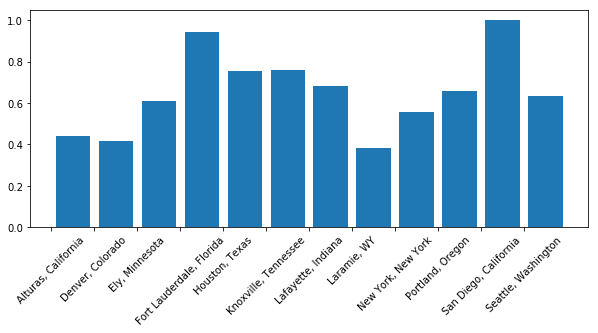



Finished in  12.63  seconds.



In [5]:
# formatted heading for output
init_str = '\n\nStarting batch simulation with ' + str(len(cities))+' cities...\n\n'
heading_str = ('{:<25}'.format('City')+ '{:>10}'.format('Damage')
              + '\n-----------------------------------')
print(init_str)
print(heading_str)

# initialize figure
fig, ax = plt.subplots(figsize=(10,4))

names = []       # names for bar chart labels
name_loc = []    # location for bar chart labels
values =[]       # value (height) of bars
bar_loc = [-0.5] # location for bars

# loop through dict of cities
for key in cities:
    
    # runs simulation, discard output other than cumulative damage
    _, _, _, _, damage_cumulative, _ = simulation(key)
    
    # get the label name and location
    names.append(cities[key])
    name_loc.append(bar_loc[-1] + 0.5)
    
    # get the bar height and location
    values.append(damage_cumulative[-1])
    bar_loc.append(bar_loc[-1]+1)
   
    # report the damage in the terminal
    out_str = ('{:<25}'.format(cities[key])+ '   {:,}'.format(round(damage_cumulative[-1]))
              + '\n-----------------------------------')
    print(out_str)

    
# plot the relative damage for all cities

print('\nDisplay relative damage...\n\n')

relative_damage = [float(i)/max(values) for i in values]
    
ax.bar(bar_loc[1:],relative_damage)
ax.set_xticks(name_loc)    
ax.set_xticklabels(names,rotation = 45)

plt.show()

print('\n\nFinished in ','%.2f' % (time.time() - st),' seconds.\n')